In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime, time
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from difflib import SequenceMatcher
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from statsmodels.regression.linear_model import OLSResults
import math

In [2]:
df = pd.read_csv("within-patch.csv")
pd.set_option('display.max_columns', None)

## Replacing Nan with 0

In [5]:
df['AcceptedAnswerId'] = df['AcceptedAnswerId'].replace(np.nan, 0)
df['Ans_lastEditDate'] = df['Ans_lastEditDate'].replace(np.nan, 0)

In [6]:
p = re.compile(r'<.*?>')

for ind, row in df.iterrows():
    title_count = p.sub('',  df.loc[ind, "Ans_Body"])
    df.loc[ind, "Words_in_Answer_Text"] = len(re.findall(r'\w+',title_count))

In [7]:
for ind, row in df.iterrows():
    if(df.loc[ind,"AcceptedAnswerId"]==df.loc[ind,"Ans_Id"]):
        df.loc[ind, "Accepted_Ans"] = df.loc[ind, "Ans_Score"]*2
    else:
        df.loc[ind, "Accepted_Ans"] = df.loc[ind, "Ans_Score"]*1.5

In [8]:
substring = "<code>"

for ind, row in df.iterrows():
    if(substring in df.loc[ind,"Ans_Body"]):
        df.loc[ind, "Code_Snippet"] = 1
    else:
        df.loc[ind, "Code_Snippet"] = 0

In [12]:
p = re.compile(r'<.*?>')

for ind, row in df.iterrows():
    title_text = p.sub('',  df.loc[ind, "Title_Body"])
    answer_text = p.sub('',  df.loc[ind, "Ans_Body"])
    question = re.findall(r'\w+',title_text)
    answer = re.findall(r'\w+',answer_text)
    df.loc[ind, "description_answer_ratio"] = math.ceil(SequenceMatcher(None, title_text,answer_text).ratio())

## Text Similarity [Title and Answer Text]

In [13]:
p = re.compile(r'<.*?>')

for ind, row in df.iterrows():
    title_text = p.sub('',  df.loc[ind, "Title"])
    answer_text = p.sub('',  df.loc[ind, "Ans_Body"])
    question = re.findall(r'\w+',title_text)
    answer = re.findall(r'\w+',answer_text)
    df.loc[ind, "que_answer_ratio"] = math.ceil(SequenceMatcher(None, title_text,answer_text).ratio()*100)

## Creation Days

In [14]:
for ind, row in df.iterrows():
    def date_diff_in_seconds(dt2, dt1):
        timedelta = dt2 - dt1
        return timedelta.days * 24 * 3600 + timedelta.seconds

    def dhms_from_seconds(seconds):
        minutes, seconds = divmod(seconds, 60)
        hours, minutes = divmod(minutes, 60)
        days, hours = divmod(hours, 24)
        return (days)
    
    #Dates
    creation_date = datetime.strptime(df.loc[ind,"CreationDate"], '%Y-%m-%dT%H:%M:%S')
    answer_creation_date = datetime.strptime(df.loc[ind,"Ans_creationDate"], '%Y-%m-%dT%H:%M:%S')
   

    #Data dump date
    dump_date = datetime.strptime('2020-12-21 01:00:00', '%Y-%m-%d %H:%M:%S')
    
    ##Difference
    creation_days = dhms_from_seconds(date_diff_in_seconds(dump_date, creation_date))
    answer_creation_days = dhms_from_seconds(date_diff_in_seconds(dump_date, answer_creation_date))
    
    ##New Colunmns
    df.loc[ind,"Answer_Creation_Days"] = creation_days - answer_creation_days  


## Answer Last Edit Days

In [15]:
for ind, row in df.iterrows():
    def date_diff_in_seconds(dt2, dt1):
        timedelta = dt2 - dt1
        return timedelta.days * 24 * 3600 + timedelta.seconds

    def dhms_from_seconds(seconds):
        minutes, seconds = divmod(seconds, 60)
        hours, minutes = divmod(minutes, 60)
        days, hours = divmod(hours, 24)
        return (days)
    
    answer_creation_date = datetime.strptime(df.loc[ind,"Ans_creationDate"], '%Y-%m-%dT%H:%M:%S')
    answer_creation_date = datetime.strptime(df.loc[ind,"Ans_creationDate"], '%Y-%m-%dT%H:%M:%S')
    
    #Data dump date
    dump_date = datetime.strptime('2020-12-21 01:00:00', '%Y-%m-%d %H:%M:%S')
    ##Difference
    creation_days = dhms_from_seconds(date_diff_in_seconds(dump_date, creation_date))
    answer_creation_days = dhms_from_seconds(date_diff_in_seconds(dump_date, answer_creation_date))
    
    #Dates
    if(df.loc[ind,"Ans_lastEditDate"]==0):
        df.loc[ind,"Answer_Last_Edit_Days"] = answer_creation_days  
        
    else:
        answer_last_edit_date = datetime.strptime(df.loc[ind,"Ans_lastEditDate"], '%Y-%m-%dT%H:%M:%S')
        #Data dump date
        dump_date = datetime.strptime('2020-12-21 01:00:00', '%Y-%m-%d %H:%M:%S')
        ##Difference
        answer_last_edit_days = dhms_from_seconds(date_diff_in_seconds(dump_date, answer_last_edit_date))
        ##New Colunmns
        df.loc[ind,"Answer_Last_Edit_Days"] = creation_days - answer_last_edit_days           

In [16]:
df['Words_in_Answer_Text'] = df['Words_in_Answer_Text'].astype(int)
df['Accepted_Ans'] = df['Accepted_Ans'].astype(int)
df['Code_Snippet'] = df['Code_Snippet'].astype(int)
df['Answer_Creation_Days'] = df['Answer_Creation_Days'].astype(int)
df['Answer_Last_Edit_Days'] = df['Answer_Last_Edit_Days'].astype(int)
df['description_answer_ratio'] = df['description_answer_ratio'].astype(int)
df['que_answer_ratio'] = df['que_answer_ratio'].astype(int)

In [17]:
df.drop(['Id', 'Score','Title', 'Title_Body', 'CreationDate','AcceptedAnswerId', 'Ans_Id','Ans_Body','Ans_creationDate', 'Ans_lastEditDate'], axis=1, inplace=True)

In [18]:
data_scaled = normalize(df)

In [19]:
hc = AgglomerativeClustering(n_clusters=2,affinity="euclidean",linkage="ward")
hc.fit(data_scaled)

AgglomerativeClustering()

In [20]:
membership = hc.labels_
membership

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(data_scaled,method='ward'))

In [21]:
df_0 = df[hc.labels_==0]

In [22]:
df_1 = df[hc.labels_==1]

In [24]:
df_1.to_csv('within_value_high.csv')

In [23]:
df_0.to_csv('within_value_low.csv')

In [76]:
silhouette_score(data_scaled,membership)

0.5053097082657437

In [77]:
df.loc[:,"Category"]=0
df.loc[hc.labels_==1, "Category"] = 1

In [78]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from statsmodels.regression.linear_model import OLSResults

In [94]:
feature_names = ['Ans_Score','Ans_CommentCount','Words_in_Answer_Text','Accepted_Ans','Answer_Creation_Days','Answer_Last_Edit_Days']
nrm_feature_names = [f"Nrm_{i}" for i in feature_names]

In [95]:
scaler = MinMaxScaler()
features = df[feature_names]
nrm_feature_names = [f"Nrm_{i}" for i in feature_names]
scaler.fit(features)
for i in nrm_feature_names:
    df[i] = 0
df[nrm_feature_names] = scaler.transform(features)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(df[nrm_feature_names], df["Category"], test_size=0.3, random_state=62)

In [100]:
lm_cluster_value = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.533088
         Iterations 8


In [101]:
print(lm_cluster_value.summary())

                           Logit Regression Results                           
Dep. Variable:               Category   No. Observations:                 3033
Model:                          Logit   Df Residuals:                     3027
Method:                           MLE   Df Model:                            5
Date:                Sun, 05 Dec 2021   Pseudo R-squ.:                  0.1534
Time:                        15:09:25   Log-Likelihood:                -1616.9
converged:                       True   LL-Null:                       -1909.8
Covariance Type:            nonrobust   LLR p-value:                2.220e-124
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Nrm_Ans_Score                53.6032     20.647      2.596      0.009      13.137      94.070
Nrm_Ans_CommentCount          3.9365      0.746      5.280      0.000       2.475     

In [102]:
y_pred = [1 if i else 0 for i in lm_cluster_value.predict(X_test)>0.5]

In [103]:
data_summary = {}

Confusion Matrix: 
[[833  67]
 [242 159]]
Accuracy: 0.7624903920061491
Precision: 0.7035398230088495
Recall: 0.39650872817955113


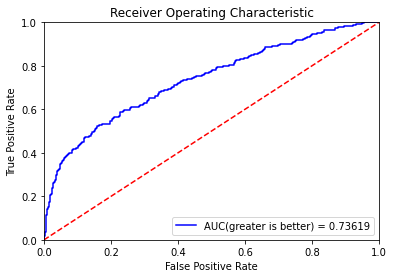

In [104]:
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
fpr, tpr, thresholds = roc_curve(y_test, lm_cluster_value.predict(X_test), pos_label=1)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC(greater is better) = {round(roc_auc, 5)}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

data_summary["Exetrems_Model_Testing_Dataset"] = {}
data_summary["Exetrems_Model_Testing_Dataset"]["Accuracy"] = accuracy_score(y_test, y_pred)
data_summary["Exetrems_Model_Testing_Dataset"]["Precision"] = precision_score(y_test, y_pred)
data_summary["Exetrems_Model_Testing_Dataset"]["Recall"] = recall_score(y_test, y_pred)
data_summary["Exetrems_Model_Testing_Dataset"]["AUC"] = auc(fpr, tpr)

Confusion Matrix: 
[[1895  156]
 [ 584  398]]
Accuracy: 0.7560171447411803
Precision: 0.7184115523465704
Recall: 0.40529531568228105


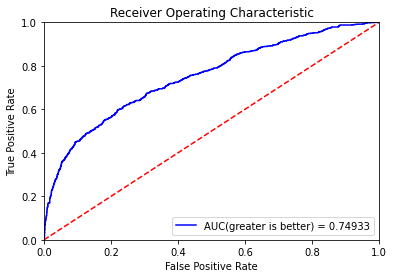

In [105]:
y_pred = [1 if i else 0 for i in lm_cluster_value.predict(X_train)>0.5]
print(f"Confusion Matrix: \n{confusion_matrix(y_train, y_pred)}")
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Precision: {precision_score(y_train, y_pred)}")
print(f"Recall: {recall_score(y_train, y_pred)}")
fpr, tpr, thresholds = roc_curve(y_train, lm_cluster_value.predict(X_train), pos_label=1)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC(greater is better) = {round(roc_auc, 5)}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

data_summary["Exetrems_Model_Training_Dataset"] = {}
data_summary["Exetrems_Model_Training_Dataset"]["Accuracy"] = accuracy_score(y_train, y_pred)
data_summary["Exetrems_Model_Training_Dataset"]["Precision"] = precision_score(y_train, y_pred)
data_summary["Exetrems_Model_Training_Dataset"]["Recall"] = recall_score(y_train, y_train)
data_summary["Exetrems_Model_Training_Dataset"]["AUC"] = auc(fpr, tpr)

In [106]:
df_python = pd.read_csv('within-python.csv')

Confusion Matrix: 
[[ 1725  4217]
 [  766 13292]]
Accuracy: 0.75085
Precision: 0.7591524358901136
Recall: 0.945511452553706


c:\users\abim\appdata\local\programs\python\python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\users\abim\appdata\local\programs\python\python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


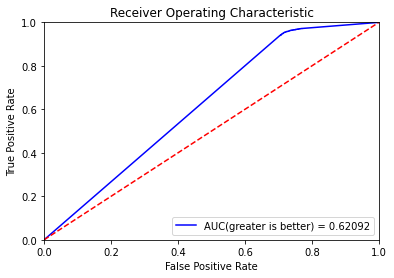

In [111]:
X_train, y_train = df_python[feature_names], df_python["Category"]
y_pred = [1 if i else 0 for i in lm_cluster_value.predict(X_train)>0.5]
print(f"Confusion Matrix: \n{confusion_matrix(y_train, y_pred)}")
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Precision: {precision_score(y_train, y_pred)}")
print(f"Recall: {recall_score(y_train, y_pred)}")
fpr, tpr, thresholds = roc_curve(y_train, lm_cluster_value.predict(X_train), pos_label=1)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC(greater is better) = {round(roc_auc, 5)}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


data_summary["Exetrems_Model_Python_Dataset"] = {}
data_summary["Exetrems_Model_Python_Dataset"]["Accuracy"] = accuracy_score(y_train, y_pred)
data_summary["Exetrems_Model_Python_Dataset"]["Precision"] = precision_score(y_train, y_pred)
data_summary["Exetrems_Model_Python_Dataset"]["Recall"] = recall_score(y_train, y_pred)
data_summary["Exetrems_Model_Python_Dataset"]["AUC"] = auc(fpr, tpr)